In [1]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [5]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings

warnings.filterwarnings("ignore")

# %matplotlib inline
# mpld3.enable_notebook()

In [3]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [7]:
# ------ Data pre-processing --------------
X_df = df_cfpdss.drop(columns="class")

# Separating categorical and non-categorical columns
categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
X_df_categorical = X_df[categorical_columns]
non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
X_df_non_categorical = X_df[non_cat_columns]

# One hot encoding - Categorical data
encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
one_hot_encoded = encoder.fit_transform(X_df_categorical)
columns = encoder.get_feature_names_out()
X_df_cat_one_hot = pd.DataFrame(one_hot_encoded, columns=columns)

# Feature scaling numerical data/non-categorical data
scaler = MinMaxScaler()
X_non_cat_df = pd.DataFrame(
    scaler.fit_transform(X_df_non_categorical), columns=scaler.get_feature_names_out()
)

# Concatenate categorical and non-categorical data
X_df_encoded = pd.concat(
    [
        X_df_cat_one_hot,
        X_non_cat_df,
    ],
    axis=1,
)

# Encoding the target variable
y_df = df_cfpdss[["class"]]
y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
y_one_hot = y_encoder.fit_transform(y_df)
y_encoded = pd.Series(y_one_hot.ravel())

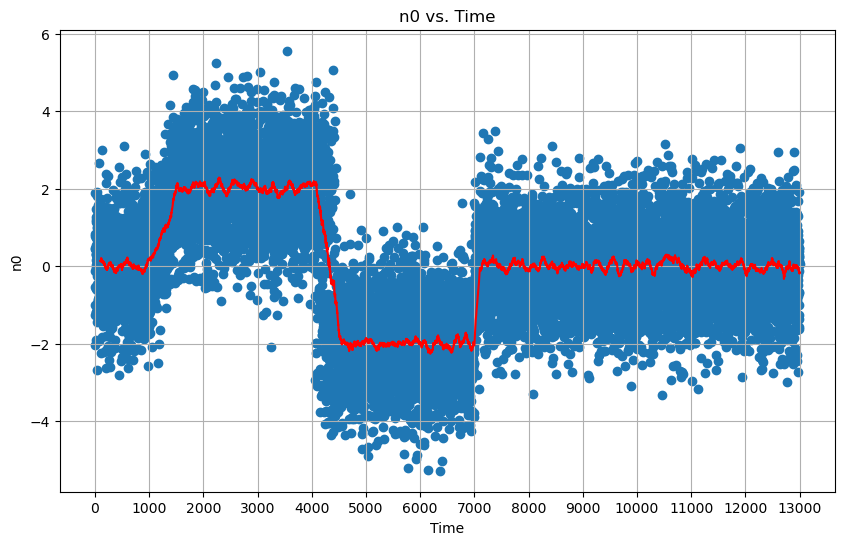

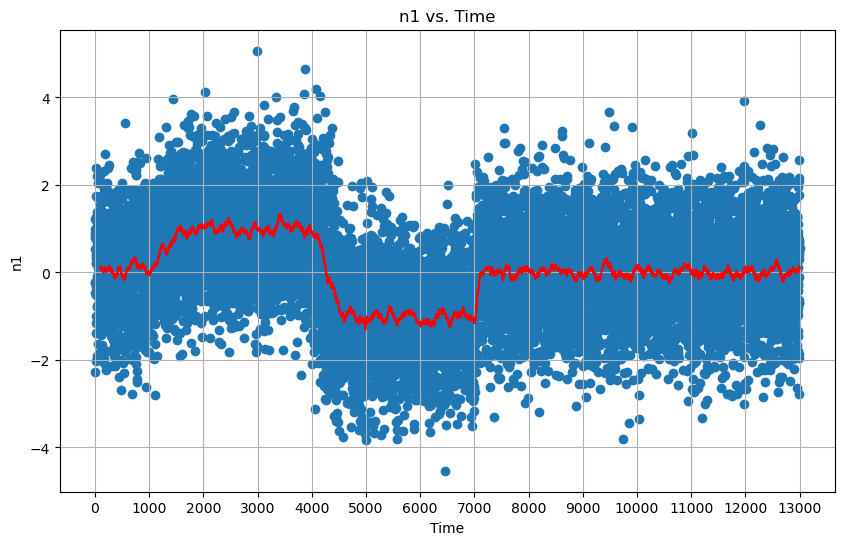

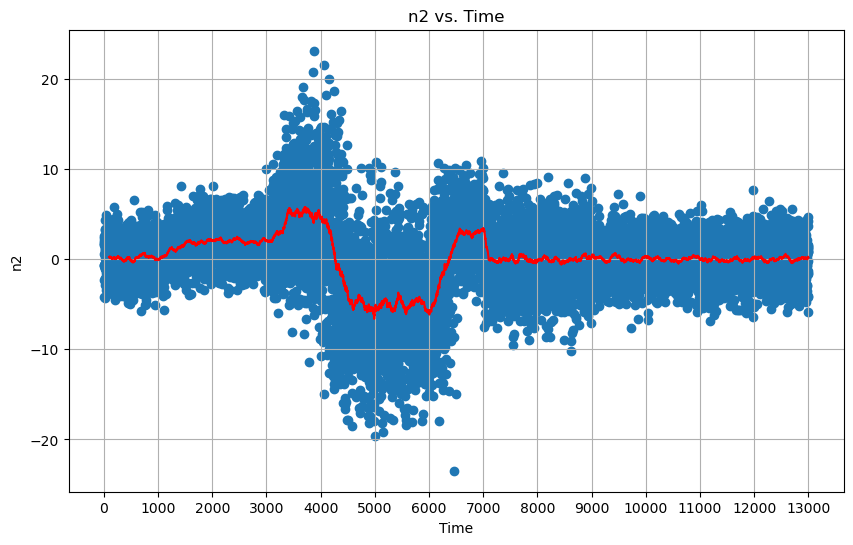

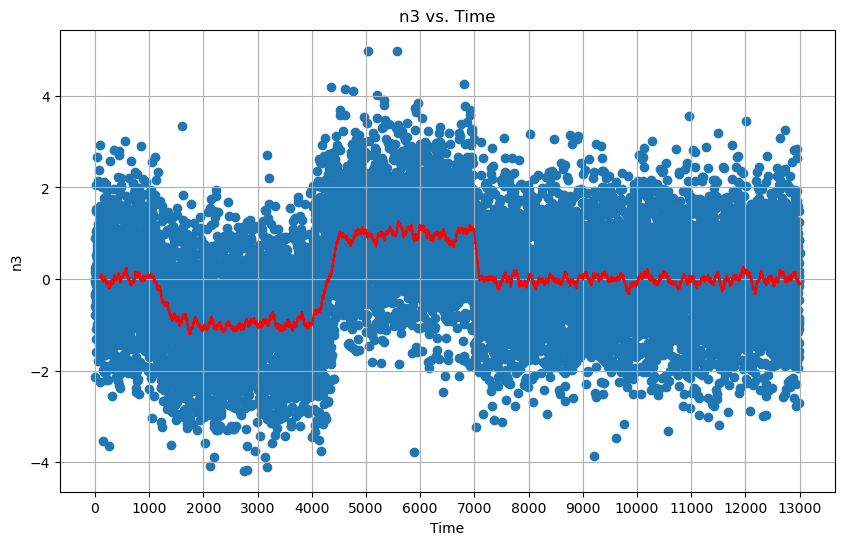

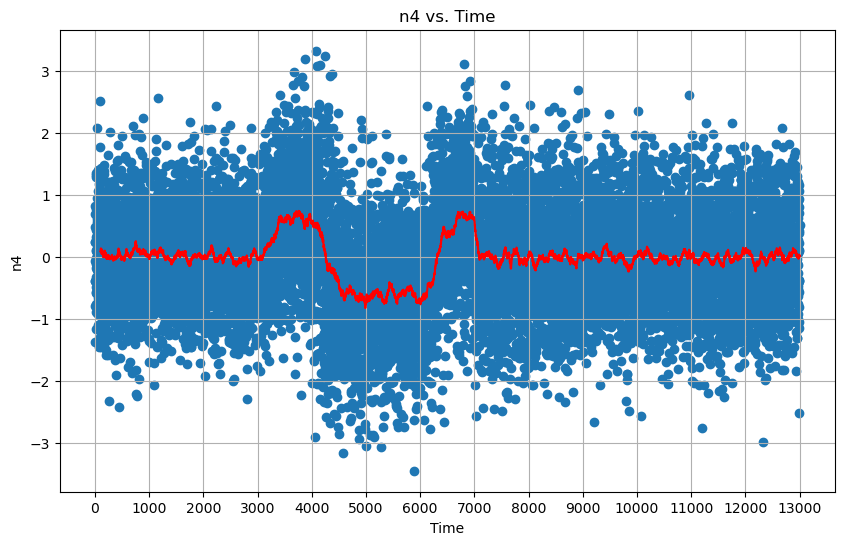

In [27]:
# Moving average plot for each numerical feature with window size 100
window_size = 100
for feature in non_cat_columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    plt.scatter(
        X_df.index,
        X_df[feature],
        marker="o",
    )

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Add a line for the moving mean
    plt.plot(
        X_df.index,
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    # plt.yticks(np.arange(-11, 11, 1))
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()

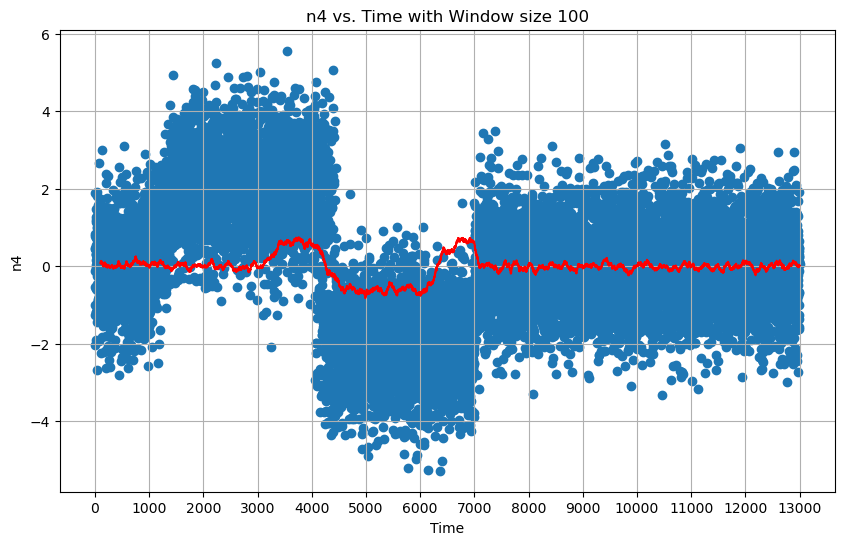

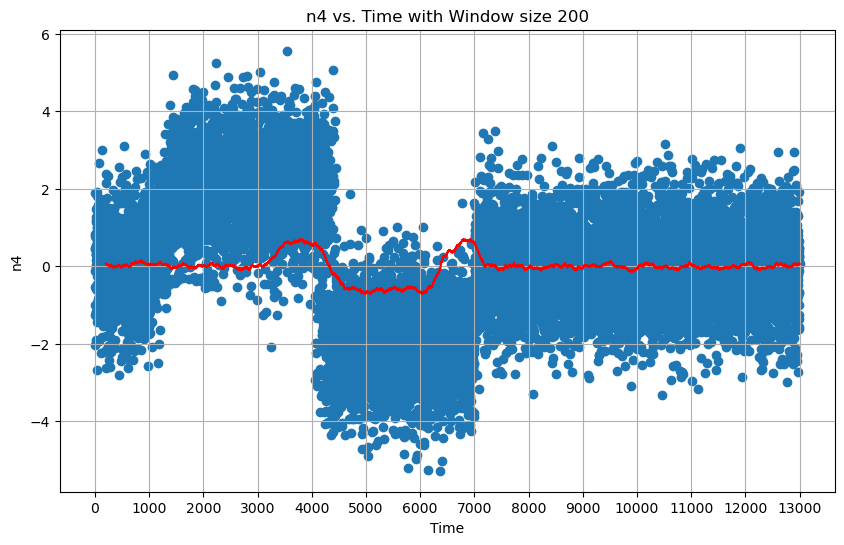

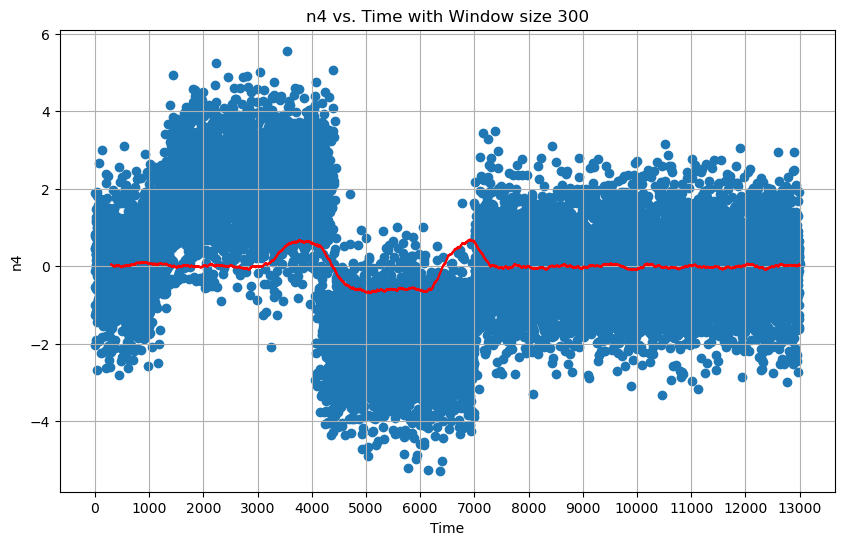

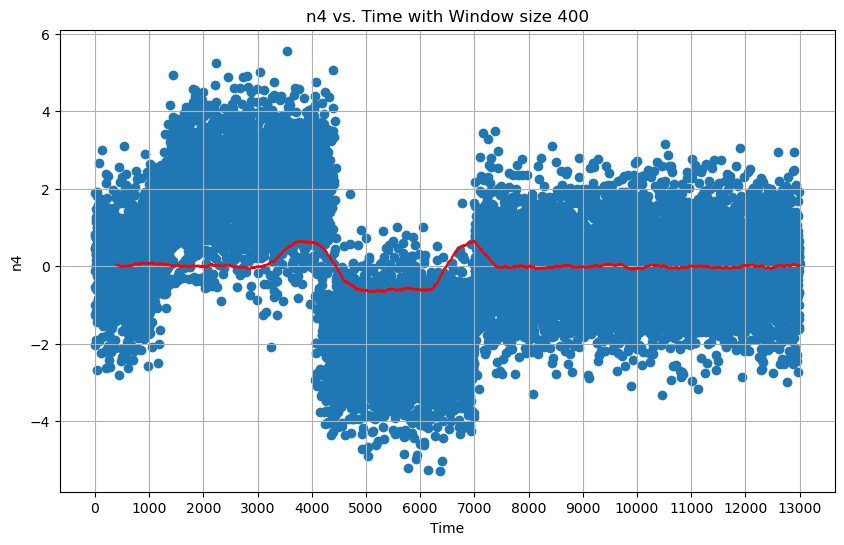

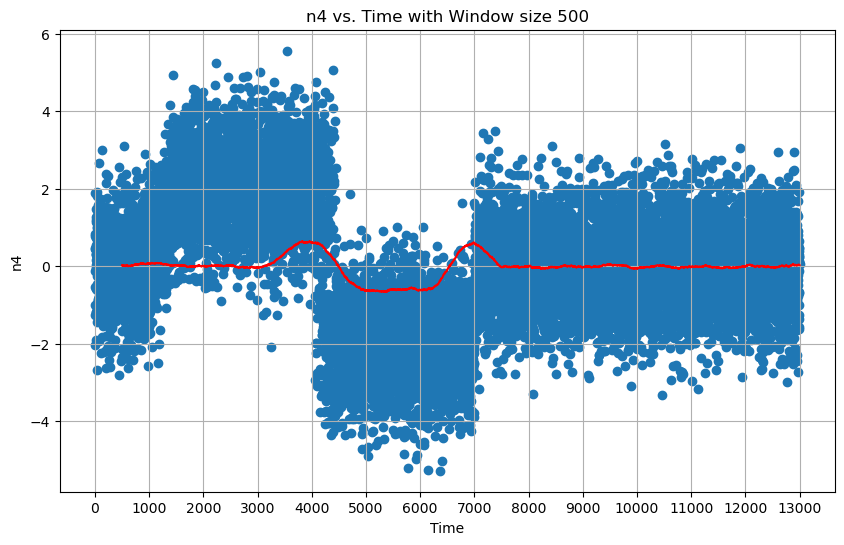

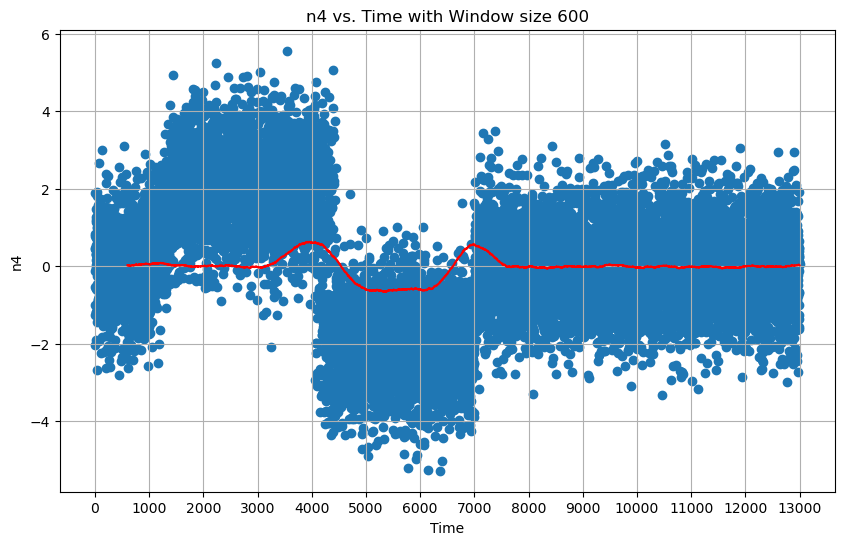

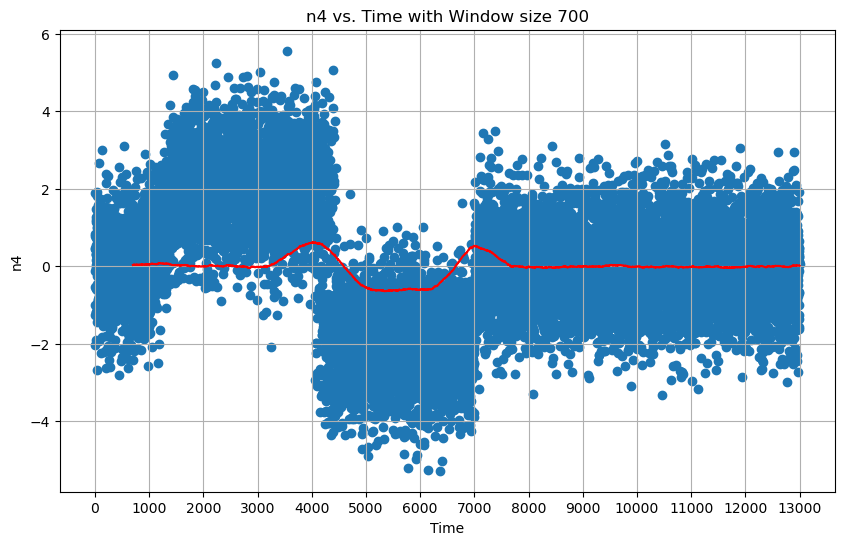

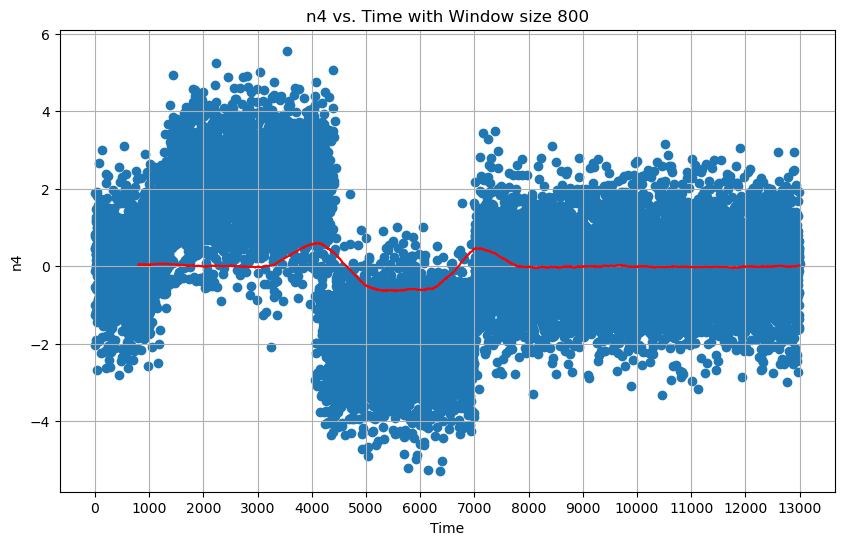

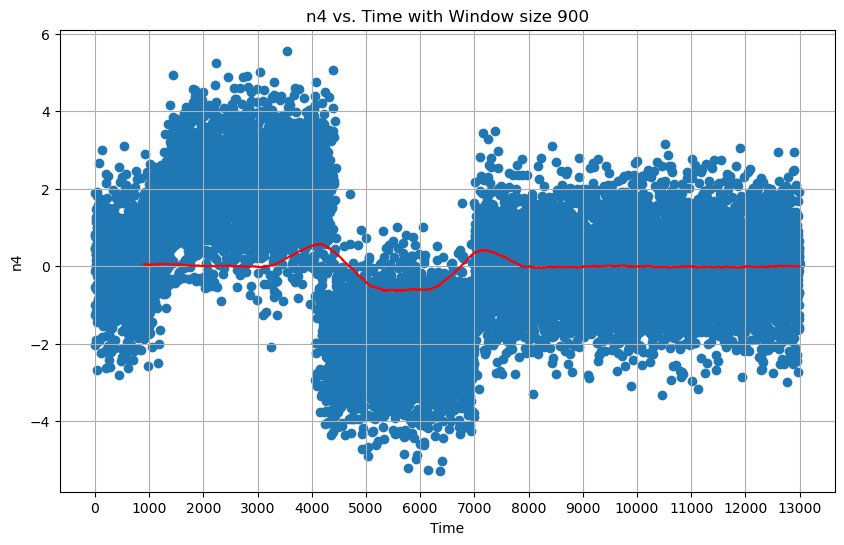

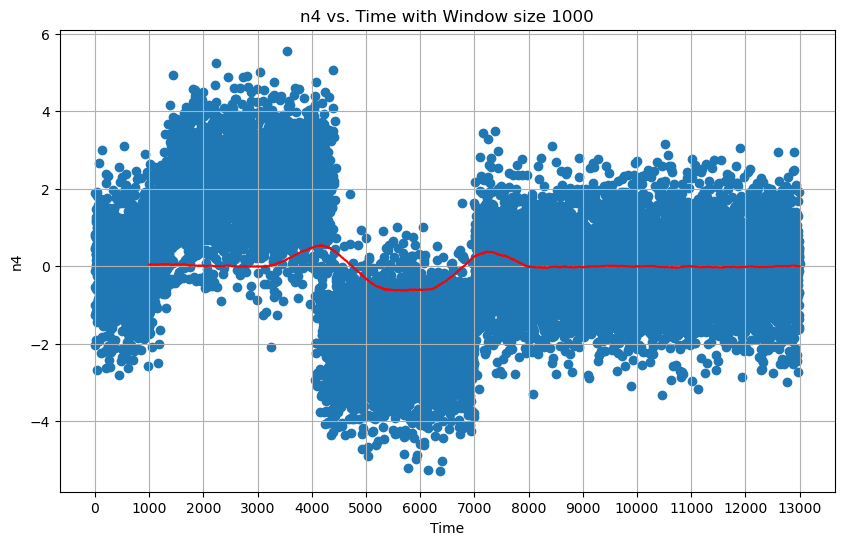

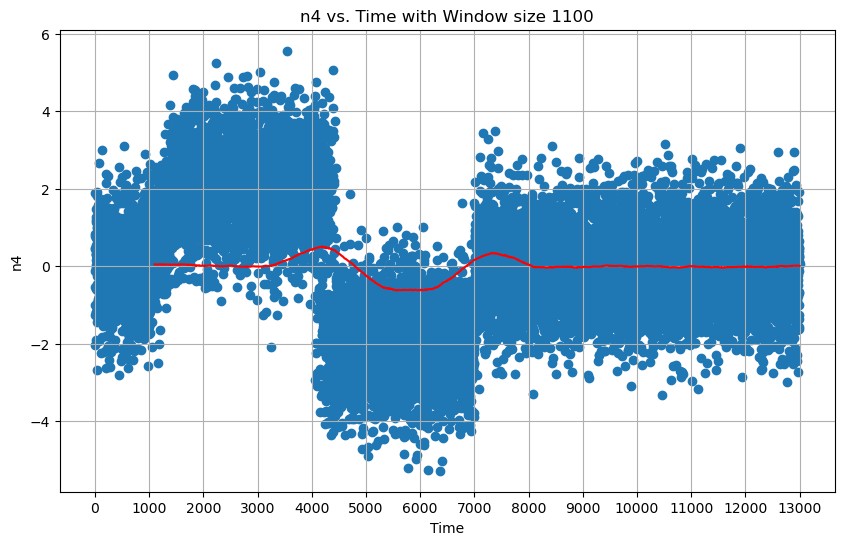

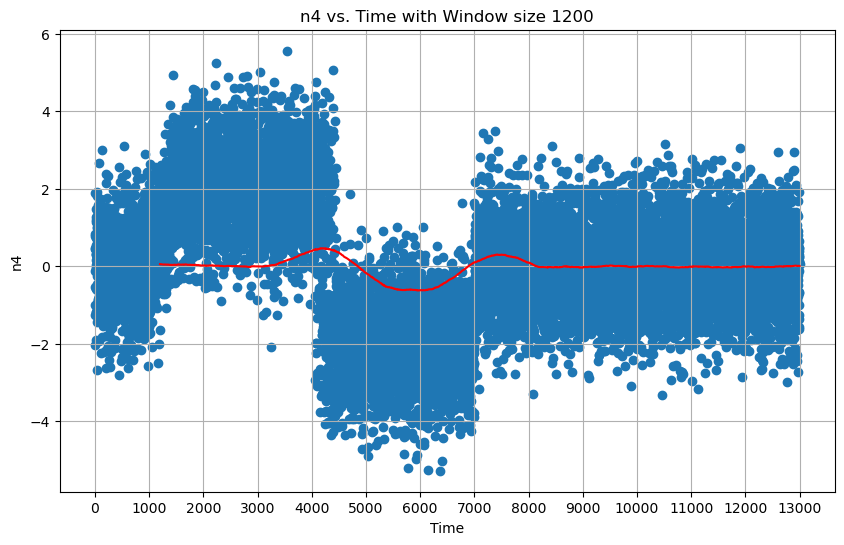

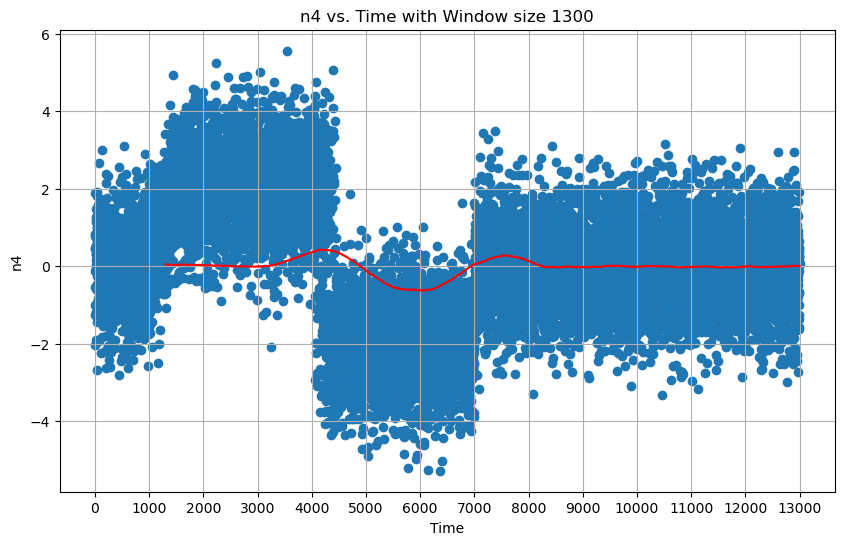

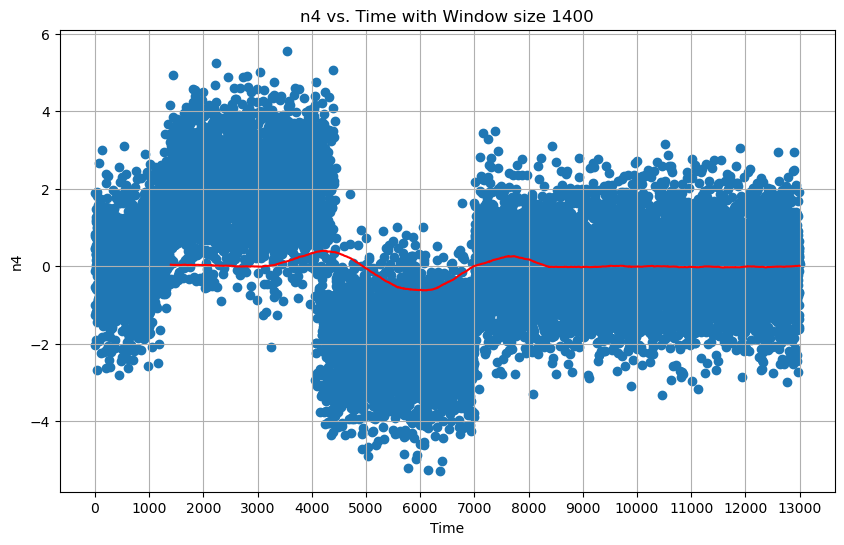

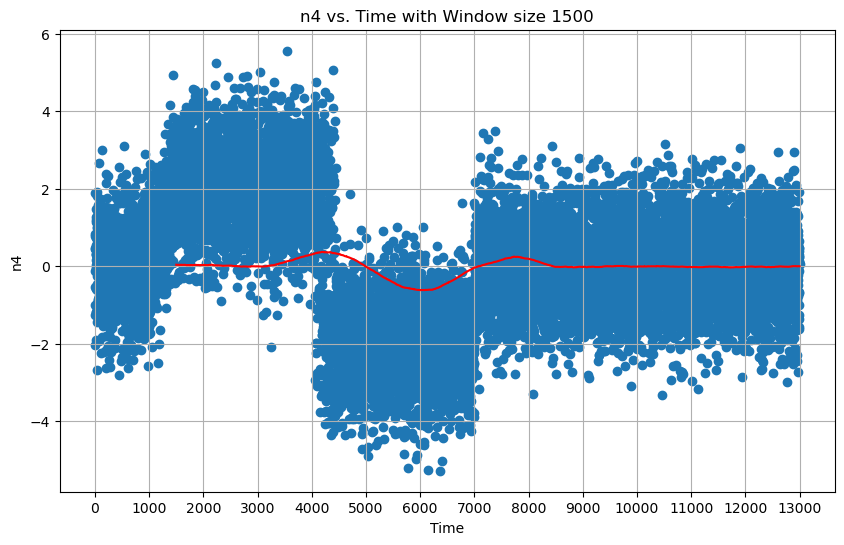

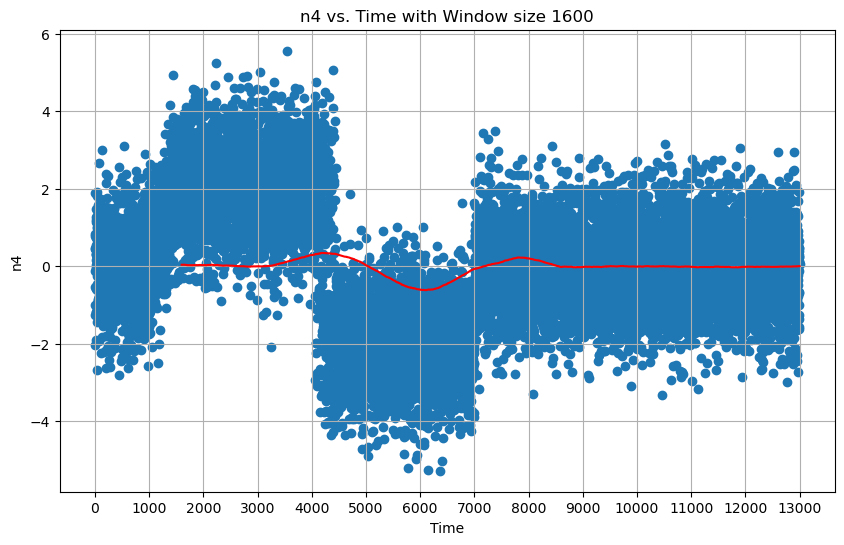

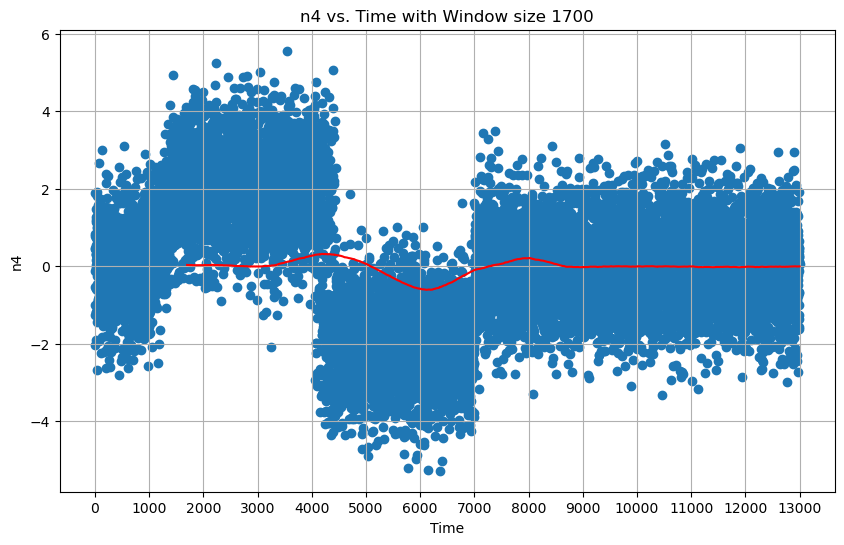

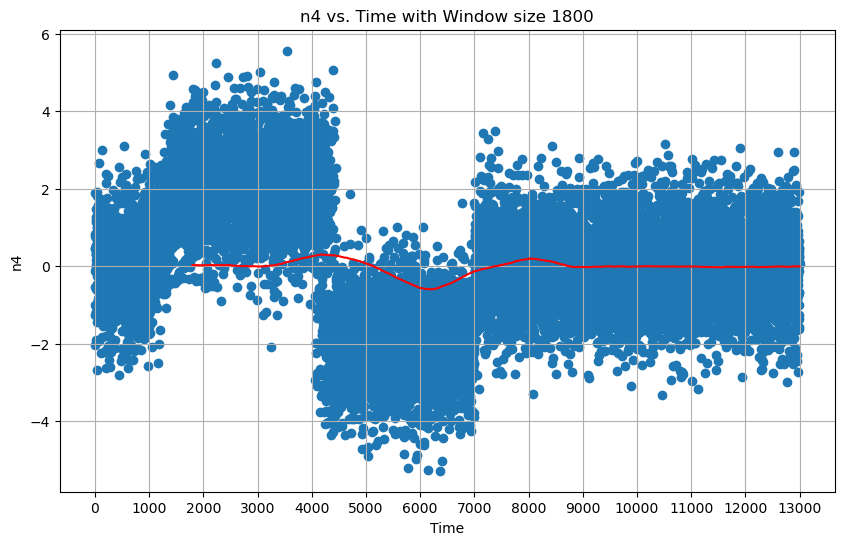

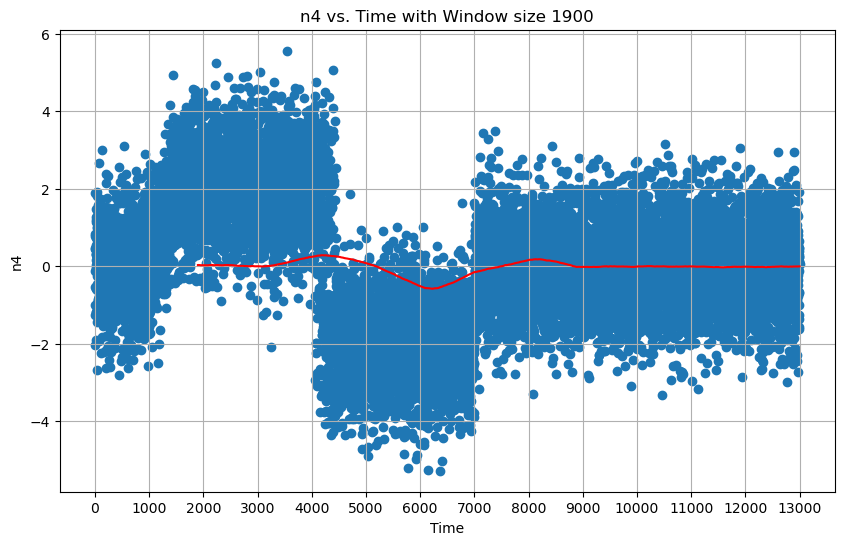

In [29]:
# Moving average plot for a particular feature with varying window size
for window_size in list(range(100, 2000, 100)):
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    plt.scatter(
        X_df.index,
        X_df["n0"],
        marker="o",
    )

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Add a line for the moving mean
    plt.plot(
        X_df.index,
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Moving Mean",
    )

    plt.title(f"{feature} vs. Time with Window size {window_size}")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    # plt.yticks(np.arange(-11, 11, 1))
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()

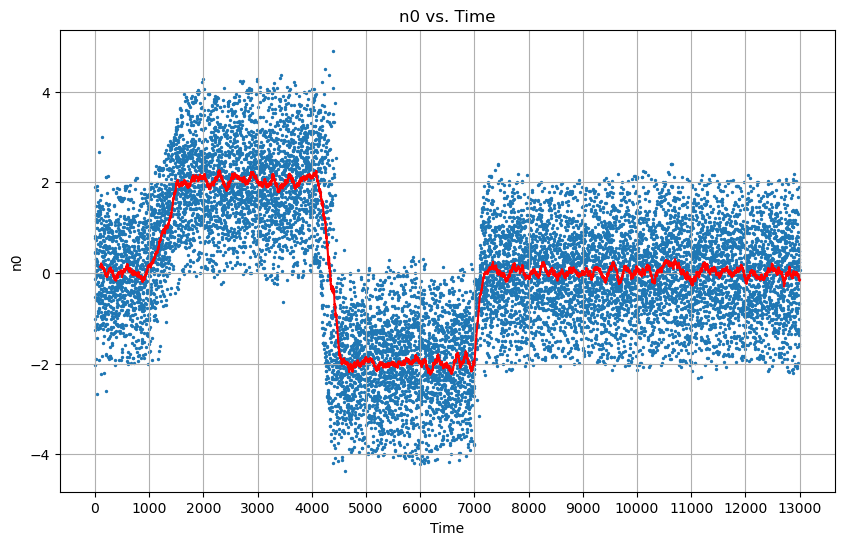

In [45]:
# Moving average plot for a numerical feature with window size 100 with trimming data to 2 stddev
window_size = 100
for feature in non_cat_columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    # plt.scatter(X_df.index, X_df[feature], marker='o', )

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Calculate the moving standard deviation of the feature
    moving_std = X_df[feature].rolling(window=window_size).std()

    # Remove noise by trimming observations to 3 standard deviations within the window
    trimmed_values = X_df[feature].copy()
    for i in range(len(X_df)):
        if i >= window_size:
            mean = moving_mean.iloc[i - window_size]
            std = moving_std.iloc[i - window_size]
            lower_bound = mean - 2 * std
            upper_bound = mean + 2 * std
            if trimmed_values.iloc[i] < lower_bound:
                trimmed_values.iloc[i] = lower_bound
            elif trimmed_values.iloc[i] > upper_bound:
                trimmed_values.iloc[i] = upper_bound

    plt.scatter(X_df.index, trimmed_values, marker="o", s=2)
    # Add a line for the trimmed moving mean
    plt.plot(
        X_df.index,
        trimmed_values.rolling(window=window_size).mean(),
        color="red",
        linestyle="-",
        label=f"{feature} Trimmed Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()
    break

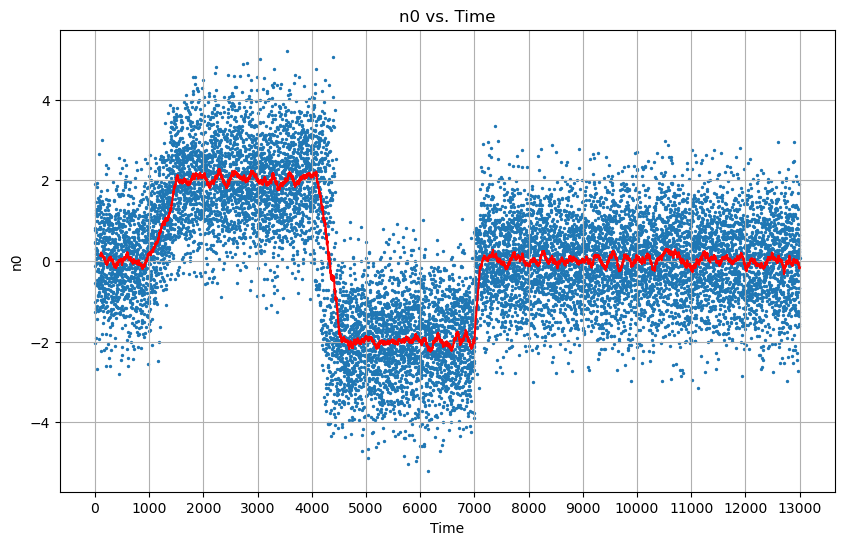

In [46]:
# Moving average plot for a numerical feature with window size 100 with trimming data to 3 stddev
window_size = 100
for feature in non_cat_columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    # plt.scatter(X_df.index, X_df[feature], marker='o', )

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Calculate the moving standard deviation of the feature
    moving_std = X_df[feature].rolling(window=window_size).std()

    # Remove noise by trimming observations to 3 standard deviations within the window
    trimmed_values = X_df[feature].copy()
    for i in range(len(X_df)):
        if i >= window_size:
            mean = moving_mean.iloc[i - window_size]
            std = moving_std.iloc[i - window_size]
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
            if trimmed_values.iloc[i] < lower_bound:
                trimmed_values.iloc[i] = lower_bound
            elif trimmed_values.iloc[i] > upper_bound:
                trimmed_values.iloc[i] = upper_bound

    plt.scatter(X_df.index, trimmed_values, marker="o", s=2)
    # Add a line for the trimmed moving mean
    plt.plot(
        X_df.index,
        trimmed_values.rolling(window=window_size).mean(),
        color="red",
        linestyle="-",
        label=f"{feature} Trimmed Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()
    break

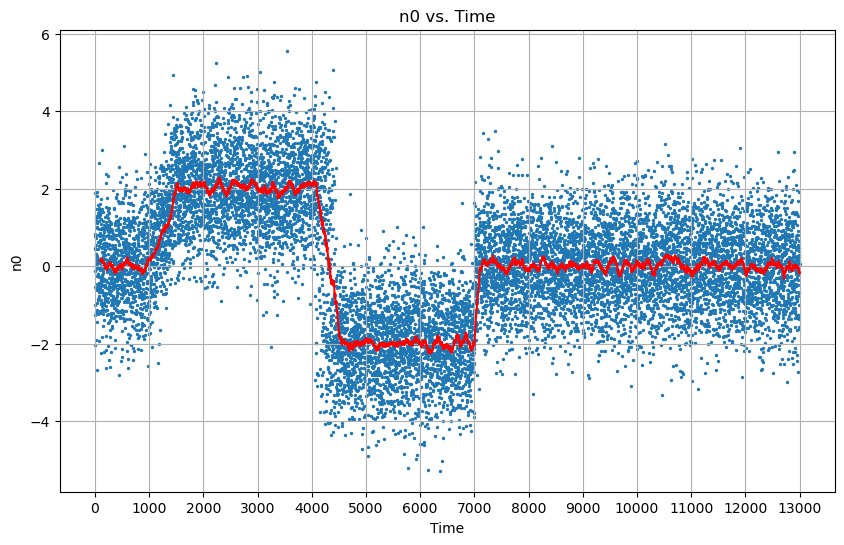

In [48]:
# Moving average plot for a numerical feature with window size 100 without
window_size = 100
for feature in non_cat_columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    plt.scatter(X_df.index, X_df[feature], marker="o", s=2)

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Add a line for the moving mean
    plt.plot(
        X_df.index,
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    # plt.yticks(np.arange(-11, 11, 1))
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()
    break